Author: Pascal, pascal@bayesimpact.org

Date: 2016-02-15

# ROME update from v329 to v330

In February 2017 I realized that they had released a new version of the ROME. I want to investigate what changed and whether we need to do anything about it.

You might not be able to reproduce this notebook, mostly because it requires to have the two versions of the ROME in your `data/rome/csv` folder which happens only just before we switch to v330. You will have to trust me on the results ;-)

Skip the run test because it requires older versions of the ROME.

In [1]:
import collections
import glob
import os
from os import path

import matplotlib_venn
import pandas

rome_path = path.join(os.getenv('DATA_FOLDER'), 'rome/csv')

OLD_VERSION = '329'
NEW_VERSION = '330'

old_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(OLD_VERSION)))
new_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(NEW_VERSION)))

First let's check if there are new or deleted files (only matching by file names).

In [2]:
new_files = new_version_files - frozenset(f.replace(OLD_VERSION, NEW_VERSION) for f in old_version_files)
deleted_files = old_version_files - frozenset(f.replace(NEW_VERSION, OLD_VERSION) for f in new_version_files)

print('{:d} new files'.format(len(new_files)))
print('{:d} deleted files'.format(len(deleted_files)))

0 new files
0 deleted files


So we have the same set of files: good start.

Now let's set up a dataset that, for each table, links the old file and the new file.

In [3]:
new_to_old = dict((f, f.replace(NEW_VERSION, OLD_VERSION)) for f in new_version_files)

# Load all datasets.
Dataset = collections.namedtuple('Dataset', ['basename', 'old', 'new'])
data = [Dataset(
        basename=path.basename(f),
        old=pandas.read_csv(f.replace(NEW_VERSION, OLD_VERSION)),
        new=pandas.read_csv(f))
    for f in sorted(new_version_files)]

def find_dataset_by_name(data, partial_name):
    for dataset in data:
        if partial_name in dataset.basename:
            return dataset
    raise ValueError('No dataset named {}, the list is\n{}'.format(partial_name, [dataset.basename for d in data]))

Let's make sure the structure hasn't changed:

In [4]:
for dataset in data:
    if set(dataset.old.columns) != set(dataset.new.columns):
        print('Columns of {} have changed.'.format(dataset.basename))

All files have the same columns as before: still good.

In [5]:
untouched = 0
for dataset in data:
    diff = len(dataset.new.index) - len(dataset.old.index)
    if diff > 0:
        print('{:d} values added in {}'.format(diff, dataset.basename))
    elif diff < 0:
        print('{:d} values removed in {}'.format(diff, dataset.basename))
    else:
        untouched += 1
print('{:d}/{:d} files with the same number of rows'.format(untouched, len(data)))

3600 values added in unix_coherence_item_v330_utf8.csv
2 values added in unix_cr_gd_dp_appellations_v330_utf8.csv
2529 values added in unix_item_arborescence_v330_utf8.csv
-554 values removed in unix_item_v330_utf8.csv
3602 values added in unix_liens_rome_referentiels_v330_utf8.csv
-2452 values removed in unix_referentiel_activite_riasec_v330_utf8.csv
-537 values removed in unix_referentiel_activite_v330_utf8.csv
2 values added in unix_referentiel_appellation_v330_utf8.csv
2403 values added in unix_referentiel_competence_v330_utf8.csv
11 values added in unix_texte_v330_utf8.csv
11/21 files with the same number of rows


So we have minor additions in half of the files. At one point we cared about `referentiel_activite` and `referentiel_activite_riasec` but have no concrete application for now.

The only interesting ones are `referentiel_appellation` and `referentiel_competence`, so let's see more precisely.

In [6]:
jobs = find_dataset_by_name(data, 'referentiel_appellation')
new_ogrs = set(jobs.new.code_ogr) - set(jobs.old.code_ogr)
new_jobs = jobs.new[jobs.new.code_ogr.isin(new_ogrs)]

job_groups = find_dataset_by_name(data, 'referentiel_code_rome_v')
pandas.merge(new_jobs, job_groups.new[['code_rome', 'libelle_rome']], on='code_rome', how='left')

,code_ogr,libelle_appellation_long,libelle_appellation_court,code_rome,code_type_section_appellation,libelle_type_section_appellation,statut,libelle_rome
0,39045,Commissaire d''expositions,Commissaire d''expositions,K1602,1,PRINCIPALE,1,Gestion de patrimoine culturel
1,39046,Agent / Agente d''entretien en crèche - halte ...,Agent / Agente d''entretien en crèche - halte ...,K2204,1,PRINCIPALE,1,Nettoyage de locaux


The new entries look legitimate.

Let's now check the `referentiel_competence`:

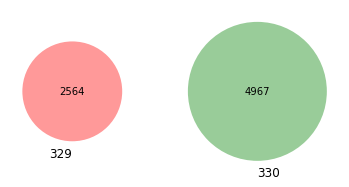

In [7]:
competences = find_dataset_by_name(data, 'referentiel_competence')
new_ogrs = set(competences.new.code_ogr) - set(competences.old.code_ogr)
obsolete_ogrs = set(competences.old.code_ogr) - set(competences.new.code_ogr)
stable_ogrs = set(competences.new.code_ogr) & set(competences.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_ogrs), len(new_ogrs), len(stable_ogrs)), (OLD_VERSION, NEW_VERSION));

Wow! All OGR codes have changed. Let's see if it's only the codes or the values as well:

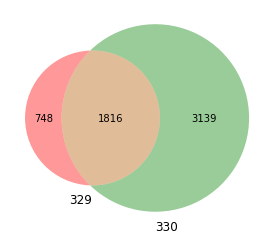

In [8]:
new_names = set(competences.new.libelle_competence) - set(competences.old.libelle_competence)
obsolete_names = set(competences.old.libelle_competence) - set(competences.new.libelle_competence)
stable_names = set(competences.new.libelle_competence) & set(competences.old.libelle_competence)

matplotlib_venn.venn2((len(obsolete_names), len(new_names), len(stable_names)), (OLD_VERSION, NEW_VERSION));

In [9]:
print('Some skills that got removed: {}…'.format(', '.join(sorted(obsolete_names)[:5])))
print('Some skills that got added: {}…'.format(', '.join(sorted(new_names)[:5])))
print('Some skills that stayed: {}…'.format(', '.join(sorted(stable_names)[:5])))

Some skills that got removed: Achevage-réglage, Acoustique, Adaptation du registre de langage, Administration de produits vétérinaires, Aiguisage des couteaux…
Some skills that got added: Accastillage, Accessoires automobile, Accordage, Accrochage, Accueil en face à face…
Some skills that stayed: Abrasion manuelle, Accidentologie, Accrochage manuel, Adaptation, composition d''oeuvres musicales, Addictologie…


OK, we will have to trust Pôle Emploi on that because the skills seem to have changed a lot. Most probably we should retry our notebooks on skills. The good thing is that our current version of Bob does not rely on skills nor skill IDs so we can just accept the change.

# Conclusion
The new version of ROME, v330, introduces a major change in the skills description, but otherwise very few additions that we feel concerned about: mainly additions of few new rows in existing files. The transition should be transparent with a very small advantage on the new one.